Epoch 0, loss 0.22679325938224792
Epoch 1000, loss 9.043332283908967e-06
Epoch 2000, loss 7.0200917434704024e-06
Epoch 3000, loss 7.1875047069625e-06
Epoch 4000, loss 0.0005228905938565731
Epoch 5000, loss 6.604368081752909e-06
Epoch 6000, loss 2.7332005174685037e-06
Epoch 7000, loss 2.0141662844253005e-06
Epoch 8000, loss 1.4695489198857103e-06
Epoch 9000, loss 3.090962127316743e-05


C:\Users\takas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


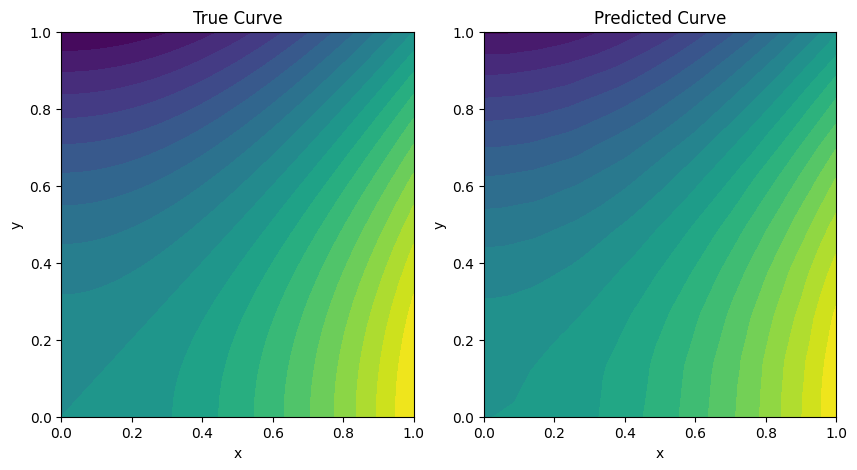

In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Define the target function
def target_function(x, y):
    return x**2 - y**2


# Define the neural network architecture
class CurveFitter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the function to train the model
def train_model(model, train_input, train_target, num_epochs, optimizer, loss_fn):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_target)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")


# Generate training data
train_input = torch.empty(1000, 2).uniform_(0, 1)
train_target = target_function(train_input[:, 0], train_input[:, 1]).unsqueeze(1)

# Define the model, loss function, and optimizer
model = CurveFitter()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_input, train_target, 10000, optimizer, loss_fn)

# Generate test input values
x_test = torch.linspace(0, 1, 100)
y_test = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x_test, y_test)

# Compute curve predictions for test input values
test_input = torch.stack([X.flatten(), Y.flatten()], axis=1)
curve_predictions = model(test_input).detach().numpy().reshape(X.shape)

# Plot the true curve and predicted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.contourf(X, Y, target_function(X, Y), levels=20, cmap='viridis')
ax.set_title('True Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the predicted curve
ax = fig.add_subplot(122)
ax.contourf(X, Y, curve_predictions, levels=20, cmap='viridis')
ax.set_title('Predicted Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Show the plot
plt.show()

In [2]:
# Set up the active learning loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(num_iterations):
    # Select a subset of the unlabeled data
    query_indices = query_strategy(unlabeled_data, model, batch_size)
    batch = unlabeled_data[query_indices]
    
    # Get the inputs and targets for the batch
    x, y = batch[:, 0], batch[:, 1]
    z_true = torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)
    
    # Initialize the hidden state
    hidden = None
    
    # Train the model on the batch
    for t in range(num_steps):
        # Get the output of the neural network
        output, hidden = model(x, y, hidden)
        
        # Compute the loss and update the neural network weights
        loss = F.mse_loss(output, z_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the test data
    test_loss = 0
    with torch.no_grad():
        for batch in test_data:
            x, y = batch[:, 0], batch[:, 1]
            z_true = torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)
            output, _ = model(x, y, None)
            test_loss += F.mse_loss(output, z_true, reduction='sum').item()
    test_loss /= len(test_data)
    
    # Print the iteration number and test loss
    print('Iteration %d: Test loss = %f' % (i, test_loss))
    
    # Select a subset of the labeled data to add to the training set
    indices_to_add = data_selection_strategy(labeled_data, model, batch_size)
    labeled_data = torch.cat([labeled_data, unlabeled_data[indices_to_add]])
    unlabeled_data = torch.cat([unlabeled_data[:query_indices[0]], unlabeled_data[query_indices[-1]+1:]])


NameError: name 'num_iterations' is not defined